## Count stats

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_d = pd.read_csv('./rvas_dataset/LAST_data_for_rvas_last.tsv', sep='\t', index_col = 'pheno.man_id')
print(data_d.shape)
data_d.head()

(860928, 92)


,kept_transcripts,genome_id,pheno.launch_id,pheno.storm,pheno.crp,pheno.leuk,pheno.neut,pheno.l,pheno.creat,pheno.crp_dynam,...,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,n_het,n_hom_ref,n_hom_var,is_alter,ref
pheno.man_id,,,,,,,,,,,,,,,,,,,,,
626630,A2M,637,63,0.0,-0.697821,-2.168169,-1.909299,-1.288741,-0.298489,1.267567,...,531,0,2.806026,0.770725,0.815385,0,1,0,0,1
620762,A2M,639,63,0.0,1.101656,0.307014,0.426411,-0.617996,-0.769107,-0.144248,...,543,0,2.690608,0.776762,0.863636,0,1,0,0,1
621011,A2M,881,88,0.0,0.350675,-0.239527,-0.022812,-0.169224,-2.013296,-0.353534,...,494,0,2.793522,0.746871,0.803571,0,1,0,0,1
627130,A2M,882,88,0.0,-0.179248,0.150065,0.163654,-0.194830,-1.988692,1.016857,...,527,0,2.869070,0.954608,0.786885,0,1,0,0,1
627508,A2M,883,88,0.0,-1.236441,-1.380005,-1.029558,-0.262704,-1.302998,0.183986,...,557,0,2.649910,0.990196,0.758621,0,1,0,0,1


How many genes do we have?

In [3]:
len(np.unique(data_d.kept_transcripts))

1121

In [4]:
def process_rvas(data_d, new_ser, feat_cut=None, _name = ''):   

    grouped_data = data_d.groupby(by=['kept_transcripts', new_ser]).agg(
        ref = pd.NamedAgg(column='ref', aggfunc=(lambda x: sum(x))), 
        var = pd.NamedAgg(column='is_alter', aggfunc=(lambda x: sum(x))),
    )
    
    
    
    print(f'======\n{new_ser}\n======')


    i = 0
    deleted = 0
    n = len(grouped_data.index)
    while i+1 < n:
        if grouped_data.iloc[i].name[0] != grouped_data.iloc[i+1].name[0]:
            grouped_data = grouped_data.drop(index=grouped_data.iloc[i].name[0])
            deleted+=1
        else:
            i+=2
        n = len(grouped_data.index)
        
    print(f"Deleted {deleted} genes.")
        
    
    genes_pval = {}
    real_pvals = {}
    pvals = []
    gene_amount = grouped_data.shape[0]//2
    for i in range(gene_amount):
        gene = grouped_data.index[2*i][0]

        alleles = grouped_data.iloc[2*i:2*i+2,0:2].to_numpy()
        real_p = fisher_exact(alleles)[1]
        pval = -np.log10(real_p)

        genes_pval.update({gene:pval})
        real_pvals.update({gene:real_p})
        pvals.append(pval)
    #     print(gene)
    #     print(alleles)
    #     print(alleles, gene, pval, sep='\n', end='\n\n')
    grouped_data.to_csv(f'out_hail_rvas/grouped_data_{new_ser}.tsv', sep = '\t')
    print(f'Genes: {gene_amount}')

    if gene_amount == 0:
        print("Don't have any genes.")
        return
    cut = -np.log10(0.05/gene_amount) # Бонферрони: 0.05/количество генов
    fig, ax = plt.subplots(figsize=(20,10))


    x = np.arange(gene_amount)
    s_p = plt.scatter(x, pvals, color = 'green')
    
    name_of_file = f'pvals_{_name.replace(" ", "_").replace("&", "_")}.csv' if _name != '' else f'pvals_{new_ser}_{feat_cut}.csv'

    with open(f'out_hail_rvas/{name_of_file}', 'w') as out_p:
        for i, txt in enumerate(genes_pval):
            pval = genes_pval[txt]
            if pval > cut - 2:
                ax.annotate(txt, (i, pval+0.1))
            out_p.write(f'{txt}, {real_pvals[txt]}\n')

    plt.plot([min(x), max(x)], [cut, cut], color = 'red')

    
    title_text = _name if _name != '' else f'{new_ser} > {feat_cut}'
    plt.title(f'Manhattan plot for {title_text}', fontsize=20)
    # Set y-axis label
    plt.ylabel('-log10(p)')
    plt.show()



    ## QQ plot
    print('QQ-plot')
    theoretical = -np.log10(np.random.uniform(0.0000000000000000001, 1, size = gene_amount))
    real = -np.log10(np.array(pvals)+0.00000000000000000001)

    theoretical = np.sort(-np.log10(np.random.uniform(0.0000000000000000001, 1, size = gene_amount)))
    real = np.sort(np.array(pvals))

    # plt.xscale('log')
    fig, ax = plt.subplots(figsize=(5,5))
    plt.grid()
    # plt.scatter(theor_pval_qq, real_pval_qq)
    plt.scatter(theoretical, real)

    plt.ylabel("Observed -log10(p)")
    plt.xlabel("Expected -log10(p)")

    max_x = max(max(theoretical), max(real))+0.06
    plt.plot([0, max_x], [0, max_x], color = 'red', linewidth = 2)
    plt.xlim(-0.05, max_x)
    plt.ylim(-0.05, max_x)
    # plt.yscale('log')
    plt.show()
    return grouped_data




## Simple features
__Chose fetures, and treat them as binary features:__

storm
Deleted 0 genes.
Genes: 1121


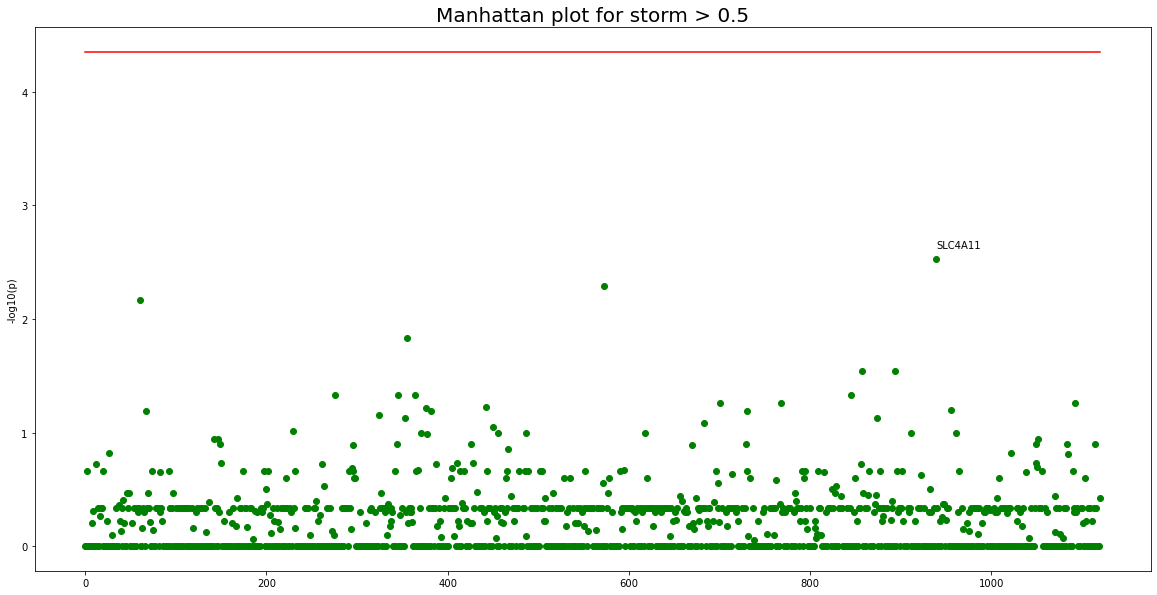

QQ-plot


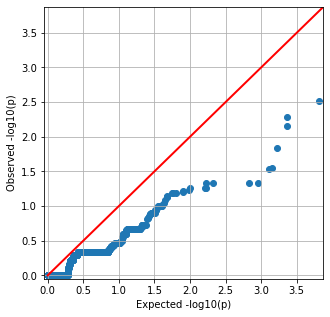

death
Deleted 0 genes.
Genes: 1121


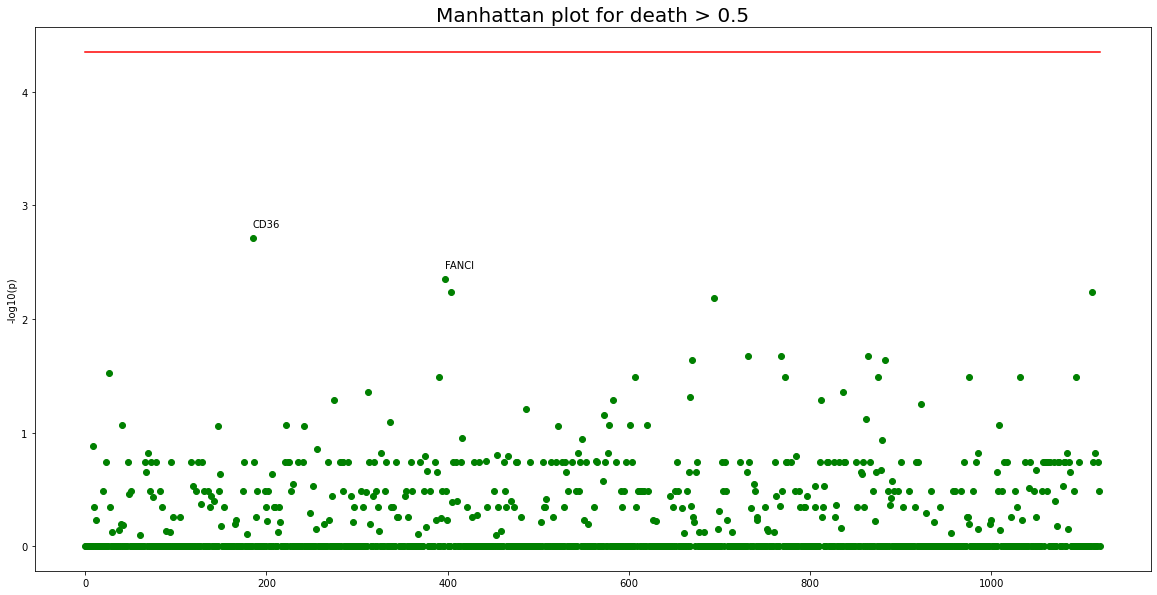

QQ-plot


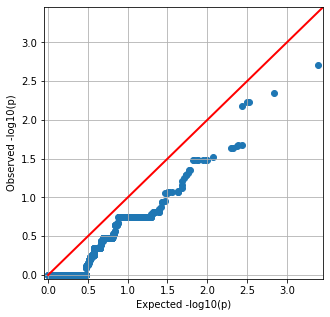

severity
Deleted 0 genes.
Genes: 1121


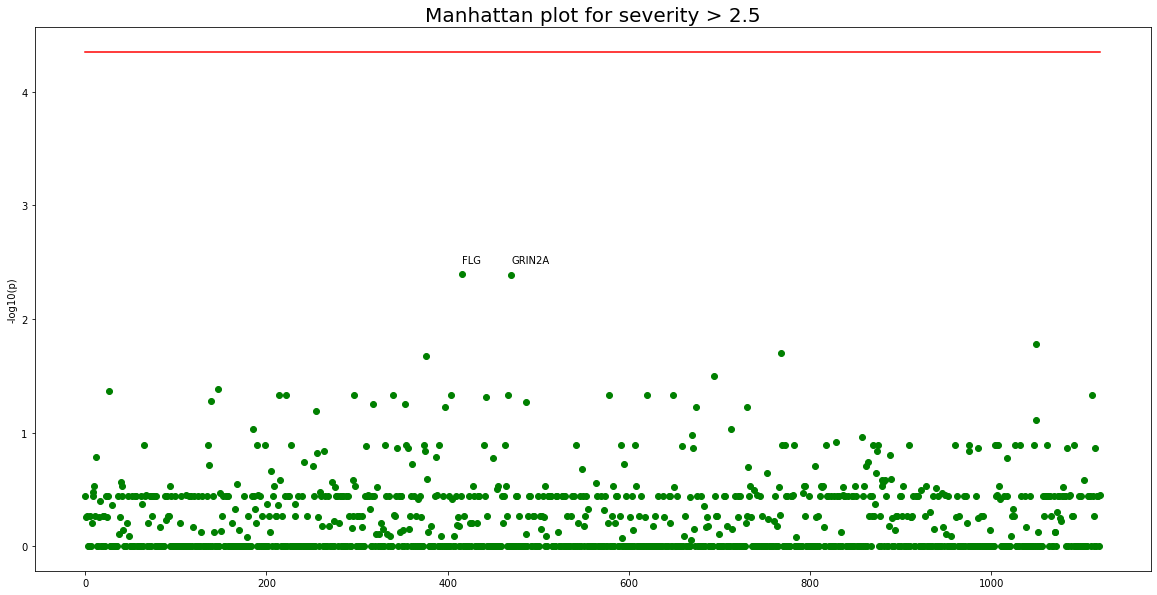

QQ-plot


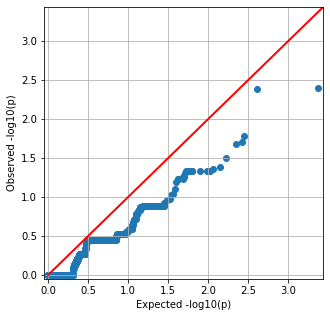

In [5]:
def dig_series_to_binary(series, cut):
    return series.apply(lambda x: int(x > cut))


ser = ['pheno.storm',  
       'pheno.death', 
       'pheno.severity']
new_ser = ['storm',
       'death', 
       'severity']
feat_cut = [0.5, 0.5, 2.5]


for s, n_s, f_c in zip(ser, new_ser, feat_cut):
    data_d[n_s] = dig_series_to_binary(data_d[s], f_c)
    process_rvas(data_d, n_s, f_c)

## Complex features:

age<50&storm
Deleted 0 genes.
Genes: 1121


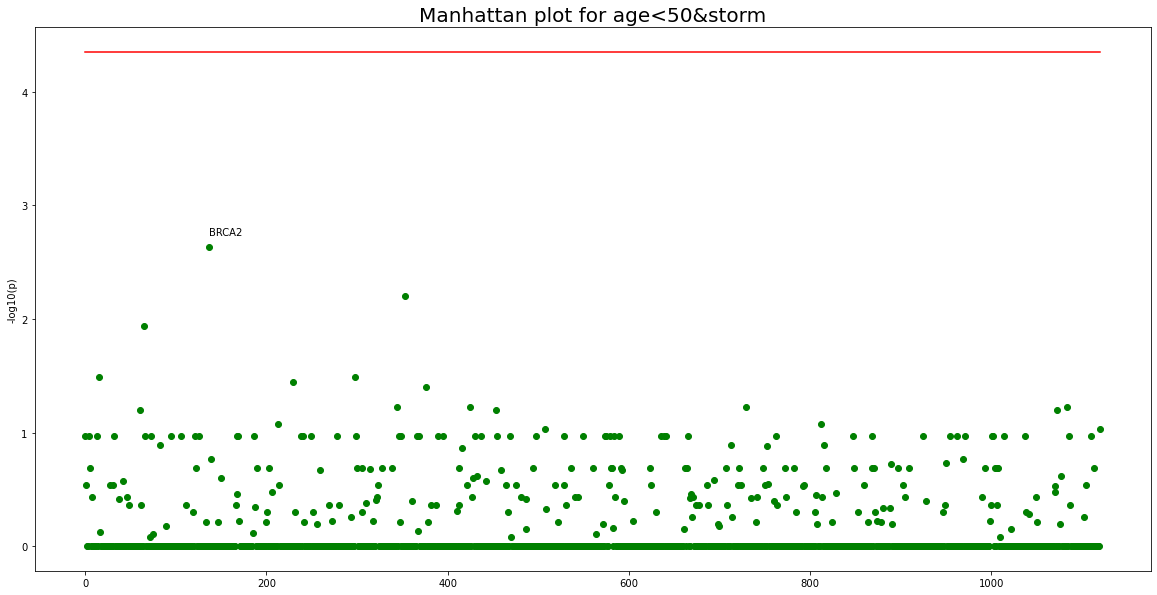

QQ-plot


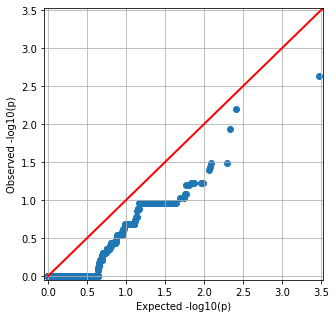

93043 VS 767885
com_index<4&storm
Deleted 0 genes.
Genes: 1121


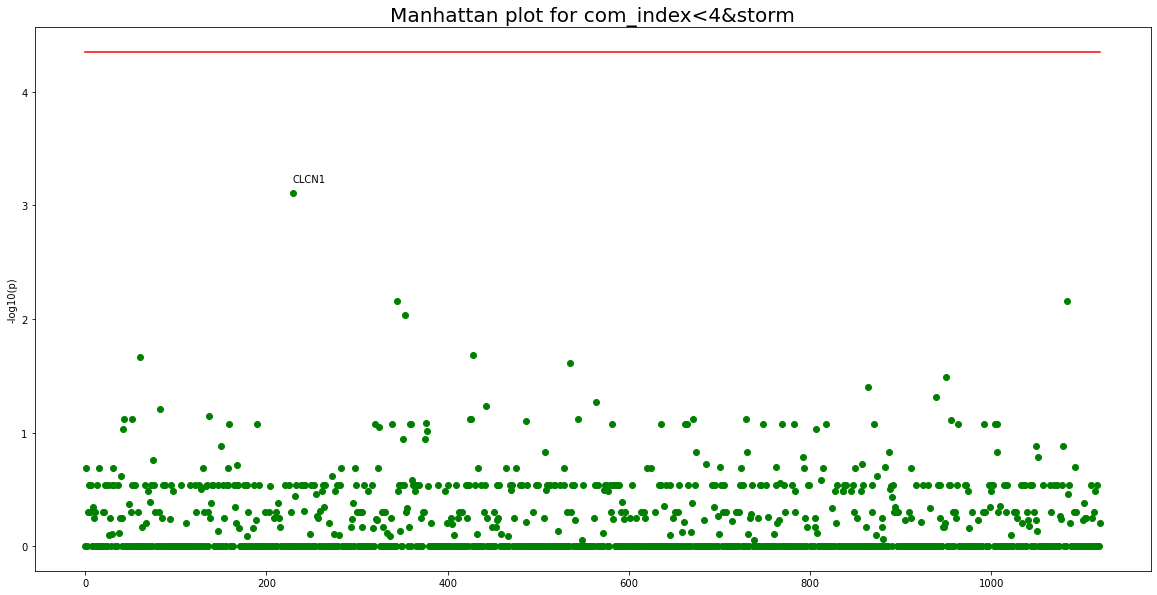

QQ-plot


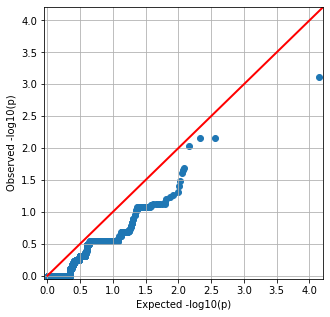

249983 VS 610945
week_to_hosp>0&storm
Deleted 0 genes.
Genes: 1121


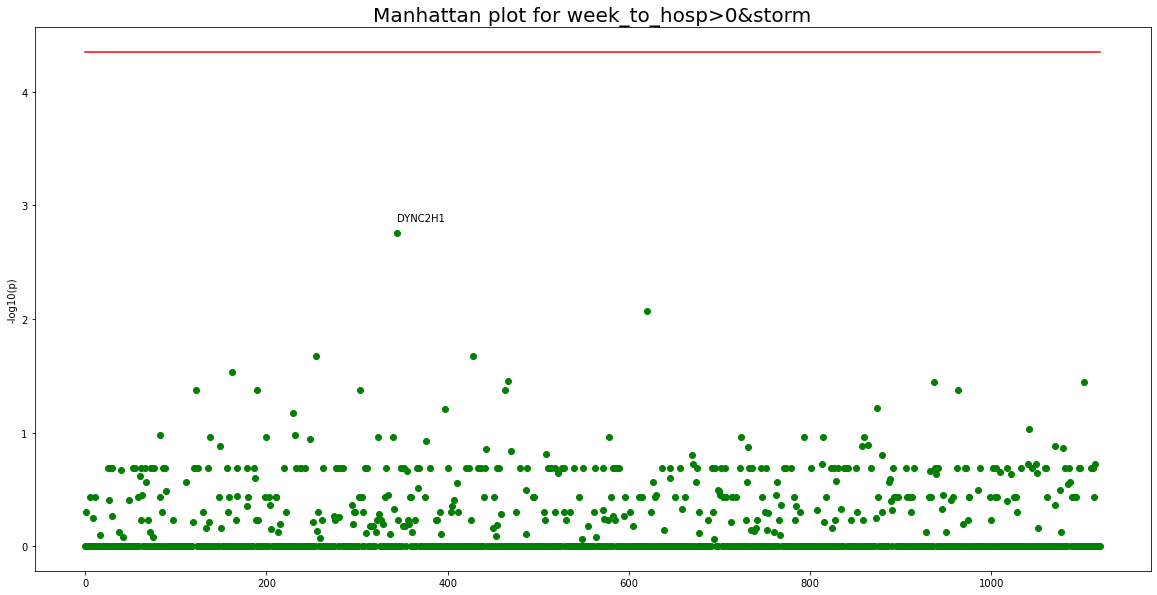

QQ-plot


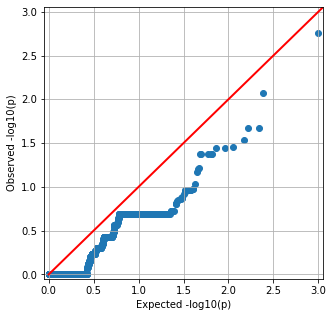

177118 VS 683810


In [7]:
#  (storm == 1) and (age < 50) VS other
#  (storm == 1) and (com_index < 4) VS other
#  (storm == 1) and (week_to_hosp > 1) VS other

ser = [
       'pheno.age',  
       'pheno.com_index', 
       'pheno.week_to_hosp'
]


name_col = 'age<50&storm'
data_d[name_col] = ((data_d['pheno.age']<50) & (data_d['pheno.storm'] == 1)).astype(int)
process_rvas(data_d, name_col, _name = name_col)
print(f'{sum(data_d[name_col])} VS {np.abs(sum(data_d[name_col]-1))}')

name_col = 'com_index<4&storm' # we take 0.063368 here, because it's IRNT values
data_d[name_col] = ((data_d['pheno.com_index']<0.063368) & (data_d['pheno.storm'] == 1)).astype(int)
process_rvas(data_d, name_col, _name = name_col)
print(f'{sum(data_d[name_col])} VS {np.abs(sum(data_d[name_col]-1))}')

name_col = 'week_to_hosp>0&storm'
data_d[name_col] = ((data_d['pheno.week_to_hosp']>0) & (data_d['pheno.storm'] == 1)).astype(int)
process_rvas(data_d, name_col, _name = name_col)
print(f'{sum(data_d[name_col])} VS {np.abs(sum(data_d[name_col]-1))}')
